## Apply Various Quantum Feature Map for Simple Datasets

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import pennylane as qml
from sklearn.datasets import load_iris
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [87]:
RANDOM_STATE = 42
DATASET = "moon"

# Seeting of Quantum Device
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

### 1. Load Simple dataset

In [88]:
# iris Dataset
if DATASET == "iris":
    iris_dataset = load_iris(as_frame=True)
    iris_df = iris_dataset["data"]
    iris_df["target"] = iris_dataset["target"]

    target_class = [0, 1]  # ['setosa', 'versicolor', 'virginica']
    iris_df = iris_df[iris_df["target"].isin(target_class)]

    # feature_cols = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
    feature_cols = ['sepal length (cm)', 'sepal width (cm)']
    # feature_cols = ['petal length (cm)', 'petal width (cm)']

    X = iris_df.loc[:, feature_cols].to_numpy()
    y = iris_df["target"].to_numpy()

In [89]:
# Moon Dataset
if DATASET == "moon":
    X, y = make_moons(n_samples=200, noise=0.1, random_state=42)

In [90]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
y_scaled = 2 * (y - 0.5)  # convert label to -1, 1

x_train, x_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.25, random_state=RANDOM_STATE
)

print(f"X train shape: {x_train.shape}")
print(f"X test shape: {x_test.shape}")
print(f"y train shape: {y_train.shape}")
print(f"y test shape: {y_test.shape}")

X train shape: (150, 2)
X test shape: (50, 2)
y train shape: (150,)
y test shape: (50,)


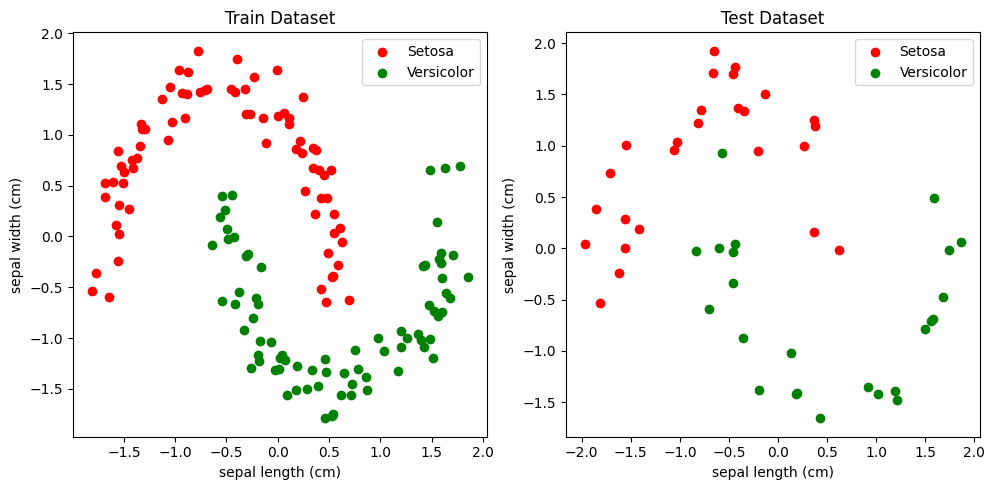

In [91]:
colors = {-1: 'red', 1: 'green'}
class_labels = {-1: 'Setosa', 1: 'Versicolor'}

plt.figure(figsize=(10, 5), tight_layout=True)

plt.subplot(1, 2, 1)
for class_value in np.unique(y_train):
    subset = x_train[np.where(y_train == class_value)]
    plt.scatter(subset[:, 0], subset[:, 1], c=colors[class_value], label=class_labels[class_value])
    plt.xlabel(f"{feature_cols[0]}")
    plt.ylabel(f"{feature_cols[1]}")
    plt.legend()
    plt.title("Train Dataset")

plt.subplot(1, 2, 2)
for class_value in np.unique(y_test):
    subset = x_test[np.where(y_test == class_value)]
    plt.scatter(subset[:, 0], subset[:, 1], c=colors[class_value], label=class_labels[class_value])
    plt.xlabel(f"{feature_cols[0]}")
    plt.ylabel(f"{feature_cols[1]}")
    plt.legend()
    plt.title("Test Dataset")

plt.show()

### 2. Compute kernel

In [92]:
# single qubit feature map
def angle_feature_map(x, rotaion_axis='X'):
    qml.AngleEmbedding(x, wires=range(n_qubits), rotation=rotaion_axis)


def h_angle_feature_map(x, rotaion_axis='Z'):
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
    qml.AngleEmbedding(x, wires=range(n_qubits), rotation=rotaion_axis)

In [100]:
# multi qubit feature map
def xx_feature_map(x, reps=1):
    for _ in range(reps):
        for i in range(n_qubits):
            qml.RX(x[i], wires=i)

        for i in range(0, n_qubits-1):
            qml.IsingXX((np.pi-x[i])*(np.pi-x[i+1]),wires=[0,1])


def yy_feature_map(x, reps=1):
    for _ in range(reps):
        for i in range(n_qubits):
            qml.Hadamard(wires=i)
            qml.RY(x[i], wires=i)

        for i in range(0, n_qubits-1):
            qml.IsingYY((np.pi-x[i])*(np.pi-x[i+1]),wires=[0,1])


def zz_feature_map(x, reps=3):
    for _ in range(reps):
        for i in range(n_qubits):
            qml.Hadamard(wires=i)
            qml.RZ(x[i], wires=i)

        for i in range(0, n_qubits-1):
            qml.IsingZZ((np.pi-x[i])*(np.pi-x[i+1]),wires=[0,1])

In [101]:
@qml.qnode(dev)
def kernel(feature_map, x1, x2):
    feature_map(x1)
    qml.adjoint(feature_map)(x2) # type: ignore
    return qml.probs(wires=range(n_qubits))


def compute_kernel(feature_map, x_array_1, x_array_2):
    n_samples_1 = len(x_array_1)
    n_samples_2 = len(x_array_2)
    kernel_matrix = np.zeros((n_samples_1, n_samples_2))

    for i in range(n_samples_1):
        for j in range(n_samples_2):
            kernel_matrix[i, j] = kernel(feature_map, x_array_1[i], x_array_2[j])[0]  # get |00> state probability
    
    return kernel_matrix

In [102]:
# Map List: [angle_feature_map, h_angle_feature_map, xx_feature_map, yy_feature_map, zz_feature_map]
FEATURE_MAP = zz_feature_map

train_kernel = compute_kernel(FEATURE_MAP, x_train, x_train)
test_kernel = compute_kernel(FEATURE_MAP, x_test, x_train)

print(f"Train Kernel Matrix Shape: {train_kernel.shape}")
print(f"Test Kernel Matrix Shape: {test_kernel.shape}")

print(qml.draw(kernel)(FEATURE_MAP, x_train[0], x_train[1]))

Train Kernel Matrix Shape: (150, 150)
Test Kernel Matrix Shape: (50, 150)
0: ──H──RZ(-1.30)─╭IsingZZ(9.27)──H──RZ(-1.30)─╭IsingZZ(9.27)──H──RZ(-1.30)─╭IsingZZ(9.27)
1: ──H──RZ(1.05)──╰IsingZZ(9.27)──H──RZ(1.05)──╰IsingZZ(9.27)──H──RZ(1.05)──╰IsingZZ(9.27)

──╭IsingZZ(8.01)†──RZ(-0.90)†──H†─╭IsingZZ(8.01)†──RZ(-0.90)†──H†─╭IsingZZ(8.01)†──RZ(-0.90)†──H†─┤
──╰IsingZZ(8.01)†──RZ(1.16)†───H†─╰IsingZZ(8.01)†──RZ(1.16)†───H†─╰IsingZZ(8.01)†──RZ(1.16)†───H†─┤

  ╭Probs
  ╰Probs


### 3. Predict by SVM

In [103]:
model = SVC(kernel="precomputed")
model.fit(train_kernel, y_train)

y_pred = model.predict(test_kernel)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n", conf_matrix)

Accuracy: 0.84

Classification Report:
               precision    recall  f1-score   support

        -1.0       0.82      0.88      0.85        26
         1.0       0.86      0.79      0.83        24

    accuracy                           0.84        50
   macro avg       0.84      0.84      0.84        50
weighted avg       0.84      0.84      0.84        50


Confusion Matrix:
 [[23  3]
 [ 5 19]]


Text(0.5, 1.0, 'Groud Truth VS Predicted (Quantum Kernel)')

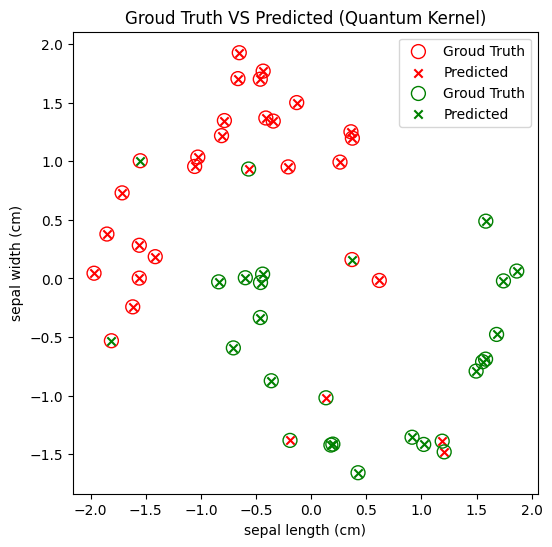

In [104]:
colors = {-1: 'red', 1: 'green'}
class_labels = {-1: 'Setosa', 1: 'Versicolor'}

plt.figure(figsize=(6, 6))

for class_value in np.unique(y_test):
    groud_subset = x_test[np.where(y_test == class_value)]
    plt.scatter(groud_subset[:, 0], groud_subset[:, 1], edgecolor=colors[class_value], facecolor='none', s=100, label="Groud Truth")

    predicted_subset = x_test[np.where(y_pred == class_value)]
    plt.scatter(predicted_subset[:, 0], predicted_subset[:, 1], marker="x", c=colors[class_value], label="Predicted")

plt.xlabel(f"{feature_cols[0]}")
plt.ylabel(f"{feature_cols[1]}")
plt.legend()
plt.title("Groud Truth VS Predicted (Quantum Kernel)")

In [117]:
def plot_decisionon_boundaries(kernel_circuit, model, x_train, x_test, y_test, step_size=.1):
    x_min, x_max = x_test[:, 0].min() - 0.5, x_test[:, 0].max() + 0.5
    y_min, y_max = x_test[:, 1].min() - 0.5, x_test[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step_size),
                        np.arange(y_min, y_max, step_size))

    # calculate kernel matrix for mesh points
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    print(f"Calculating Kernel Matrix for {len(mesh_points)} mesh points")
    K_mesh = compute_kernel(kernel_circuit, mesh_points, x_train)

    # Predict the mesh points
    Z = model.predict(K_mesh)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(6, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.5, levels=[-1, 0, 1])

    neg_subset = x_test[np.where(y_test == -1)]
    plt.scatter(neg_subset[:, 0], neg_subset[:, 1], marker="o", color="black")
    pos_subset = x_test[np.where(y_test == 1)]
    plt.scatter(pos_subset[:, 0], pos_subset[:, 1], marker="x", color="black")

    plt.xlabel(f"{feature_cols[0]}")
    plt.ylabel(f"{feature_cols[1]}")

Calculating Kernel Matrix for 2254 mesh points


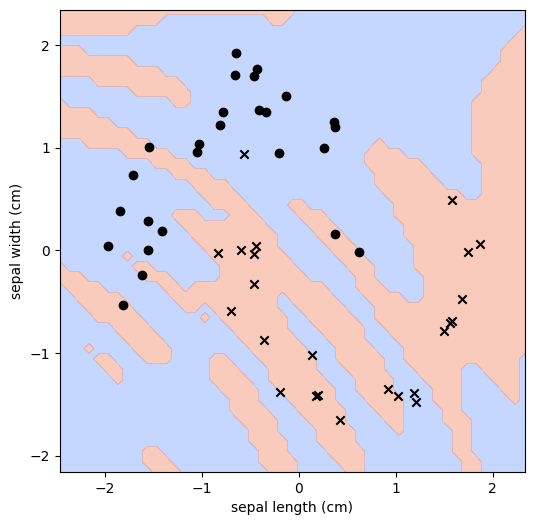

In [119]:
# step_size=0.5, 100 data point  ->  ZZ Feature Map: 17sec
# step_size=0.1, 2254 data point  ->  ZZ Feature Map: 7min5sec
plot_decisionon_boundaries(FEATURE_MAP, model, x_train, x_test, y_test, step_size=0.1)

### Appendix: Compute by classic model

In [120]:
classic_model = SVC(kernel='rbf', random_state=RANDOM_STATE)
classic_model.fit(x_train, y_train)

y_pred = classic_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n", conf_matrix)

Accuracy: 0.98

Classification Report:
               precision    recall  f1-score   support

        -1.0       0.96      1.00      0.98        26
         1.0       1.00      0.96      0.98        24

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50


Confusion Matrix:
 [[26  0]
 [ 1 23]]


Text(0.5, 1.0, 'Groud Truth VS Predicted (Classic Kernel)')

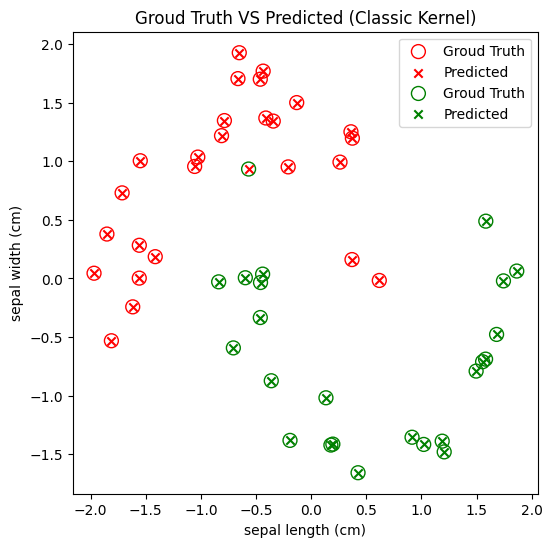

In [121]:
colors = {-1: 'red', 1: 'green'}
class_labels = {-1: 'Setosa', 1: 'Versicolor'}

plt.figure(figsize=(6, 6))

for class_value in np.unique(y_test):
    groud_subset = x_test[np.where(y_test == class_value)]
    plt.scatter(groud_subset[:, 0], groud_subset[:, 1], edgecolor=colors[class_value], facecolor='none', s=100, label="Groud Truth")

    predicted_subset = x_test[np.where(y_pred == class_value)]
    plt.scatter(predicted_subset[:, 0], predicted_subset[:, 1], marker="x", c=colors[class_value], label="Predicted")

plt.xlabel(f"{feature_cols[0]}")
plt.ylabel(f"{feature_cols[1]}")
plt.legend()
plt.title("Groud Truth VS Predicted (Classic Kernel)")

Text(0, 0.5, 'sepal width (cm)')

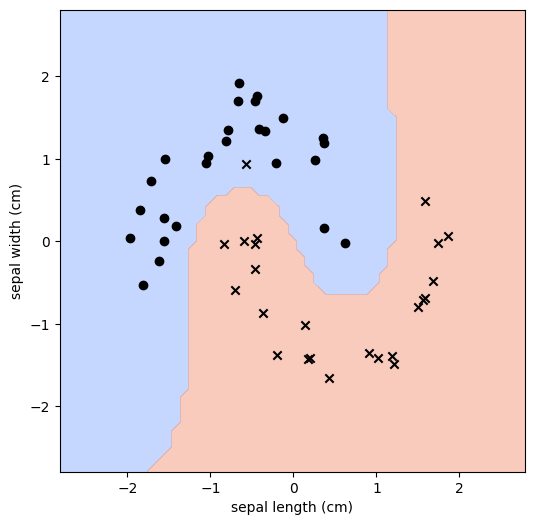

In [122]:
step_size = 0.1  
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, step_size),
                    np.arange(y_min, y_max, step_size))

# calculate kernel matrix for mesh points
mesh_points = np.c_[xx.ravel(), yy.ravel()]

# Predict the mesh points
Z = classic_model.predict(mesh_points)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.5, levels=[-1, 0, 1])

neg_subset = x_test[np.where(y_test == -1)]
plt.scatter(neg_subset[:, 0], neg_subset[:, 1], marker="o", color="black")
pos_subset = x_test[np.where(y_test == 1)]
plt.scatter(pos_subset[:, 0], pos_subset[:, 1], marker="x", color="black")

plt.xlabel(f"{feature_cols[0]}")
plt.ylabel(f"{feature_cols[1]}")